In [ ]:
# checking out the pyscenic results
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs, modules_from_adjacencies
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.prune import prune2df, df2regulons

from IPython.display import HTML, display
from dask.distributed import Client, LocalCluster

In [570]:
!pwd

/groups/mb928_gp/mp4486/Pyscenic/neurogenesis


In [571]:
modules_from_adjacencies?

Signature:
modules_from_adjacencies(
    adjacencies: pandas.core.frame.DataFrame,
    ex_mtx: pandas.core.frame.DataFrame,
    thresholds=(0.75, 0.9),
    top_n_targets=(50,),
    top_n_regulators=(5, 10, 50),
    min_genes=20,
    absolute_thresholds=False,
    rho_dichotomize=True,
    keep_only_activating=True,
    rho_threshold=0.03,
    rho_mask_dropouts=False,
) -> Sequence[ctxcore.genesig.Regulon]
Docstring:
Create modules from a dataframe containing weighted adjacencies between a TF and its target genes.

:param adjacencies: The dataframe with the TF-target links. This dataframe should have the following columns:
    :py:const:`pyscenic.utils.COLUMN_NAME_TF`, :py:const:`pyscenic.utils.COLUMN_NAME_TARGET` and :py:const:`pyscenic.utils.COLUMN_NAME_WEIGHT` .
:param ex_mtx: The expression matrix (n_cells x n_genes).
:param thresholds: the first method to create the TF-modules based on the best targets for each transcription factor.
:param top_n_targets: the second method is to sel

In [812]:
# Read in all 50 regulons sets
from collections import defaultdict

regulon_dict = defaultdict(list)
regulon_list = []

for i in range(50):
    with open(f'multi_runs2/regulons{i}.p', 'rb') as f:
        regs = pickle.load(f)

    regulon_list.append(regs)
    for j in range(len(regs)):
        name = regs[j].name
        targets = regs[j].gene2weight
        regulon_dict[name].append(targets)



In [813]:
len(regulon_dict.keys())

228

In [814]:
regulon_dict.keys()

dict_keys(['ARX(+)', 'BCLAF1(+)', 'FOXC1(+)', 'KLF12(+)', 'NFIB(+)', 'SOX9(+)', 'STAT1(+)', 'TCF12(+)', 'UBE2K(+)', 'YY1(+)', 'HIVEP2(+)', 'NFE2L1(+)', 'NKX6-1(+)', 'TCF4(+)', 'ZBTB16(+)', 'ZNF148(+)', 'ENO1(+)', 'FOXF2(+)', 'CEBPD(+)', 'ELK1(+)', 'JUN(+)', 'JUND(+)', 'KLF9(+)', 'NR2F1(+)', 'GTF2I(+)', 'NFIX(+)', 'PROX1(+)', 'SMAD4(+)', 'THRA(+)', 'MEIS2(+)', 'TCF7L2(+)', 'TRPS1(+)', 'BHLHE41(+)', 'GATA2(+)', 'KLF4(+)', 'LEF1(+)', 'NKX6-2(+)', 'SOX2(+)', 'SOX6(+)', 'ZNF536(+)', 'FOS(+)', 'SHOX2(+)', 'ZNF91(+)', 'BPTF(+)', 'MAF(+)', 'MEF2C(+)', 'RFX7(+)', 'STAT3(+)', 'ZBTB38(+)', 'FLI1(+)', 'FOXC2(+)', 'MEF2D(+)', 'NR2F2(+)', 'PEG3(+)', 'ARID5A(+)', 'DLX2(+)', 'ZBTB18(+)', 'ZNF721(+)', 'BACH2(+)', 'NFIA(+)', 'PBX1(+)', 'RFX3(+)', 'PAX6(+)', 'POU2F1(+)', 'ASCL2(+)', 'ATF2(+)', 'IRX3(+)', 'MXI1(+)', 'POU3F2(+)', 'PURA(+)', 'ZNF407(+)', 'EGR3(+)', 'SIX5(+)', 'TFCP2(+)', 'FOXS1(+)', 'POU2AF1(+)', 'BACH1(+)', 'HMX1(+)', 'OLIG2(+)', 'NR3C2(+)', 'HLF(+)', 'DLX6(+)', 'FOXJ3(+)', 'OTX1(+)', 'FOX

In [820]:
# Re-create pyscenic regulon class
from frozendict import frozendict

class Regulon:
    def __init__(
        self,
        name,
        transcription_factor,
        gene2weight,
        gene2occurrence=None,
        context=None,
        score=0.0,
        nes=0.0,
        orthologous_identity=0.0,
        similarity_qvalue=0.0,
        annotation="",
    ):
        self.name = name
        self.transcription_factor = transcription_factor
        self.gene2weight = frozendict(gene2weight)
        self.gene2occurrence = frozendict(gene2occurrence or {})
        self.context = frozenset(context) if context else frozenset()
        self.score = score
        self.nes = nes
        self.orthologous_identity = orthologous_identity
        self.similarity_qvalue = similarity_qvalue
        self.annotation = annotation

    @property
    def genes(self):
        """Return the set of target genes."""
        return set(self.gene2weight.keys())

    def __getitem__(self, gene):
        return self.gene2weight[gene]

    def __len__(self):
        return len(self.gene2weight)

    def __repr__(self):
        return f"Regulon(name={self.name}, gene2weight:{self.gene2weight}, transcription_factor={self.transcription_factor}, n_targets={len(self.gene2weight)})"


In [841]:
# Aggregate regulons from each run only keep the genes and regulons that occur in 10 or more of the runs

from collections import Counter, defaultdict

aggregated_regulons = {}
min_gene_freq_threshold = 0.25 # filter genes that appear in ≥ 50% of runs
min_regulon_fraction = 0.25 # keep TFs where ≥ 50% of runs had *non-empty* gene dicts

for tf, gene_dicts in regulon_dict.items():
    gene_counter = Counter()
    gene_weights = defaultdict(list)
    
    for gdict in gene_dicts:
        for gene, weight in gdict.items():
            gene_counter[gene] += 1
            gene_weights[gene].append(weight)
    
    num_runs = len(gene_dicts)
    if num_runs == 0:
        continue
    
    gene2freq = {gene: count / num_runs for gene, count in gene_counter.items()}
    gene2avg_weight = {gene: sum(wts)/len(wts) for gene, wts in gene_weights.items()}

    # Filter genes
    confident_genes = {gene: gene2avg_weight[gene] for gene, freq in gene2freq.items() if freq >= min_gene_freq_threshold}

    # Keep TF only if confident genes exist *and* regulon appears in ≥ 50% of runs
    if confident_genes and (len([gd for gd in gene_dicts if gd]) / num_runs) >= min_regulon_fraction:
        aggregated_regulons[tf] = confident_genes


In [842]:
len(aggregated_regulons)

215

In [843]:
consensus_regulons = []

for tf, gene2weight in aggregated_regulons.items():
    reg = Regulon(
        name=f"{tf}",
        transcription_factor=tf,
        gene2weight=frozendict(gene2weight),
        gene2occurrence=frozendict(),  # Can also fill in frequencies here if desired
        context=frozenset(),
        score=0.0,
        nes=0.0,
        orthologous_identity=0.0,
        similarity_qvalue=0.0,
        annotation=""
    )
    consensus_regulons.append(reg)

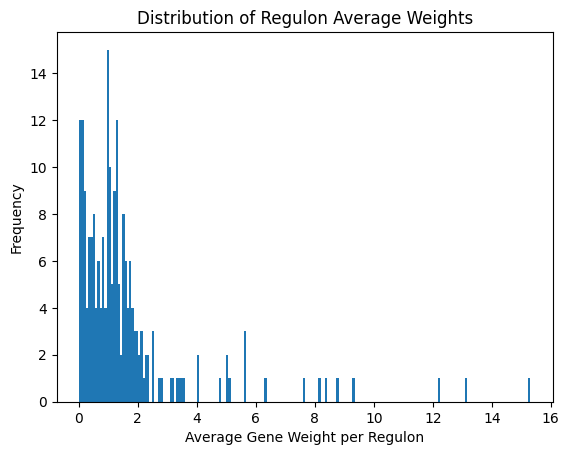

In [844]:
import matplotlib.pyplot as plt

avg_weights = [
    sum(r.gene2weight.values()) / len(r.gene2weight)
    for r in consensus_regulons if len(r.gene2weight) > 0
]

plt.hist(avg_weights, bins=200)
plt.xlabel("Average Gene Weight per Regulon")
plt.ylabel("Frequency")
plt.title("Distribution of Regulon Average Weights")
plt.show()

In [845]:
data = []

for regulon in consensus_regulons:
    tf = regulon.transcription_factor  # Extract the transcription factor (TF)
    
    # Extract the gene2weight frozendict
    gene2weight = regulon.gene2weight
    
    # For each target gene and its weight, create a row
    for gene, weight in gene2weight.items():
        data.append({'Regulon (TF)': tf, 'Target Gene': gene, 'Weight': weight})

# Step 3: Convert the list into a pandas DataFrame
df = pd.DataFrame(data)
df.to_csv('regulons_output.csv', index=False)


In [846]:
df

,Regulon (TF),Target Gene,Weight
0,BCLAF1(+),XRCC5,0.416400
1,BCLAF1(+),CENPH,0.951777
2,BCLAF1(+),TMEM167A,0.198701
3,BCLAF1(+),PRPF6,0.342940
4,BCLAF1(+),MTMR9,0.122074
...,...,...,...
5490,EMX2(+),PTN,1.019640
5491,EMX2(+),LINC00092,5.859685
5492,ZSCAN5B(+),SPON2,0.073577
5493,ZNF721(-),ZBTB46-AS1,1.095014


In [848]:
elk1 = df[df['Regulon (TF)'] == 'ELK1(+)'].sort_values('Weight', ascending=False)


In [918]:
df[df['Regulon (TF)'] == 'NR2C2(-)'].sort_values('Weight', ascending=False).head(60)


,Regulon (TF),Target Gene,Weight


In [922]:
df.to_csv("neurogenic_trajectory_regulons_12.24.25.csv")

In [858]:
adata = sc.read_h5ad("../../scgpt/data/rna_iter9_leidein_scgpt.h5ad")
umap_srat = pd.read_csv("../../palantir/immature_umap_wnn5.csv", index_col=0)
to_sub = list(umap_srat.index)
adata_subset = adata[adata.obs['sample_barcode'].isin(to_sub)]

In [859]:
sub_1 = pd.read_csv('../../tobias/astro_gn_subset_annotations_09.10.25.csv', index_col=0)
adata_subset.obs['astro_gc_wnn'] = sub_1.astype('category')

/tmp/mp4486/ipykernel_2709877/842175536.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['astro_gc_wnn'] = sub_1.astype('category')


In [860]:
adata_mtx = adata_subset.X.toarray()
exp_df = pd.DataFrame(data=adata_mtx, index=adata_subset.obs_names, columns=adata_subset.var_names)

In [861]:
auc_mtx = aucell(exp_df, consensus_regulons, num_workers = 32)

In [862]:
auc_mtx.to_csv('auc_matrix.csv', index=True)

In [863]:
# Specify the path where you want to save the pickle file
pickle_file_path = 'all_regulons.pkl'

# Step 1: Open the file in write-binary mode and save the regulons object
with open(pickle_file_path, 'wb') as file:
    pickle.dump(consensus_regulons, file)

In [864]:
# Turn aucell matrix into anndata obj with the meta from adata
aucell_adata = sc.AnnData(X=auc_mtx)
aucell_adata.obs = adata_subset.obs

In [865]:
aucell_adata.obsm['X_wnn.umap'] = adata_subset.obsm['X_wnn.umap']

In [867]:
import igraph as ig
sc.pp.neighbors(aucell_adata)
sc.tl.leiden(aucell_adata)
sc.tl.umap(aucell_adata)

/users/mp4486/.local/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 215 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/tmp/mp4486/ipykernel_2709877/942244521.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(aucell_adata)


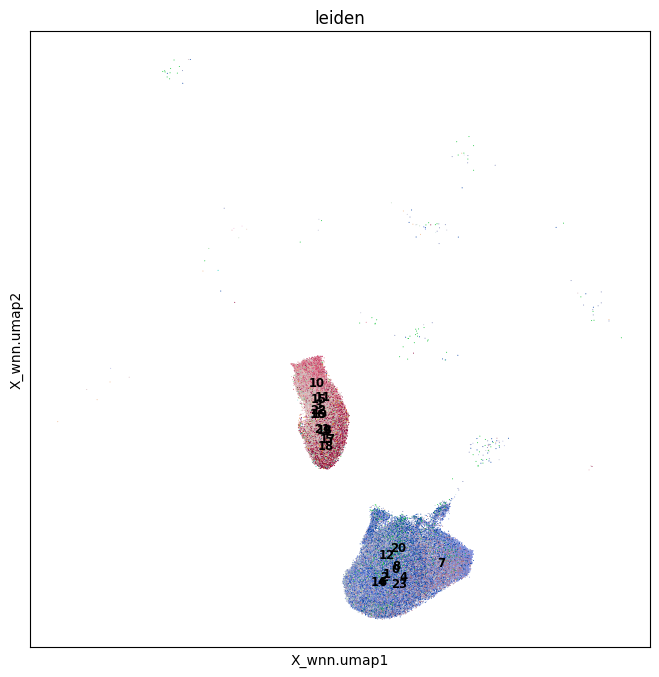

In [869]:
from matplotlib import rcParams


FIGSIZE = (8, 8)
rcParams["figure.figsize"] = FIGSIZE
sc.pl.embedding(aucell_adata, basis='X_wnn.umap', color=['leiden'],legend_loc='on data', legend_fontsize='small', show=True, size=2, legend_fontweight='black')

In [870]:
rss_cellType = regulon_specificity_scores(auc_mtx, aucell_adata.obs['astro_gc_wnn'])

In [ ]:
rss_Diagnosis = regulon_specificity_scores(auc_mtx, aucell_adata.obs['Diagnosis'])